In [1]:
from src.utils.check_mps_device import check_mps_device
import pandas as pd

from src.utils.data_loading import load_data
from src.utils.filtering import filter_data

from src.utils.label_encoding import label_encode_column

import seaborn as sns
import matplotlib.pyplot as plt

# Set the display option to show all rows and columns
# pd.set_option('display.max_rows'', None)
# pd.set_option('display.max_columns', None)

# Check if PyTorch Multi-Process Service (MPS) is available (GPU)
check_mps_device()

tensor([1.], device='mps:0')


In [2]:
# Load data
df = load_data()
df_filtered = filter_data(df)

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


## Correlation Matrix

Top Features:
c_time_lastob_end        0.323182
mahalanobis_distance     0.319083
c_time_lastob_start      0.288227
time_to_tca              0.269303
c_obs_used               0.260370
max_risk_estimate        0.244755
miss_distance            0.214056
c_obs_available          0.201404
t_rcs_estimate           0.174223
c_recommended_od_span    0.152450
Name: risk, dtype: float64


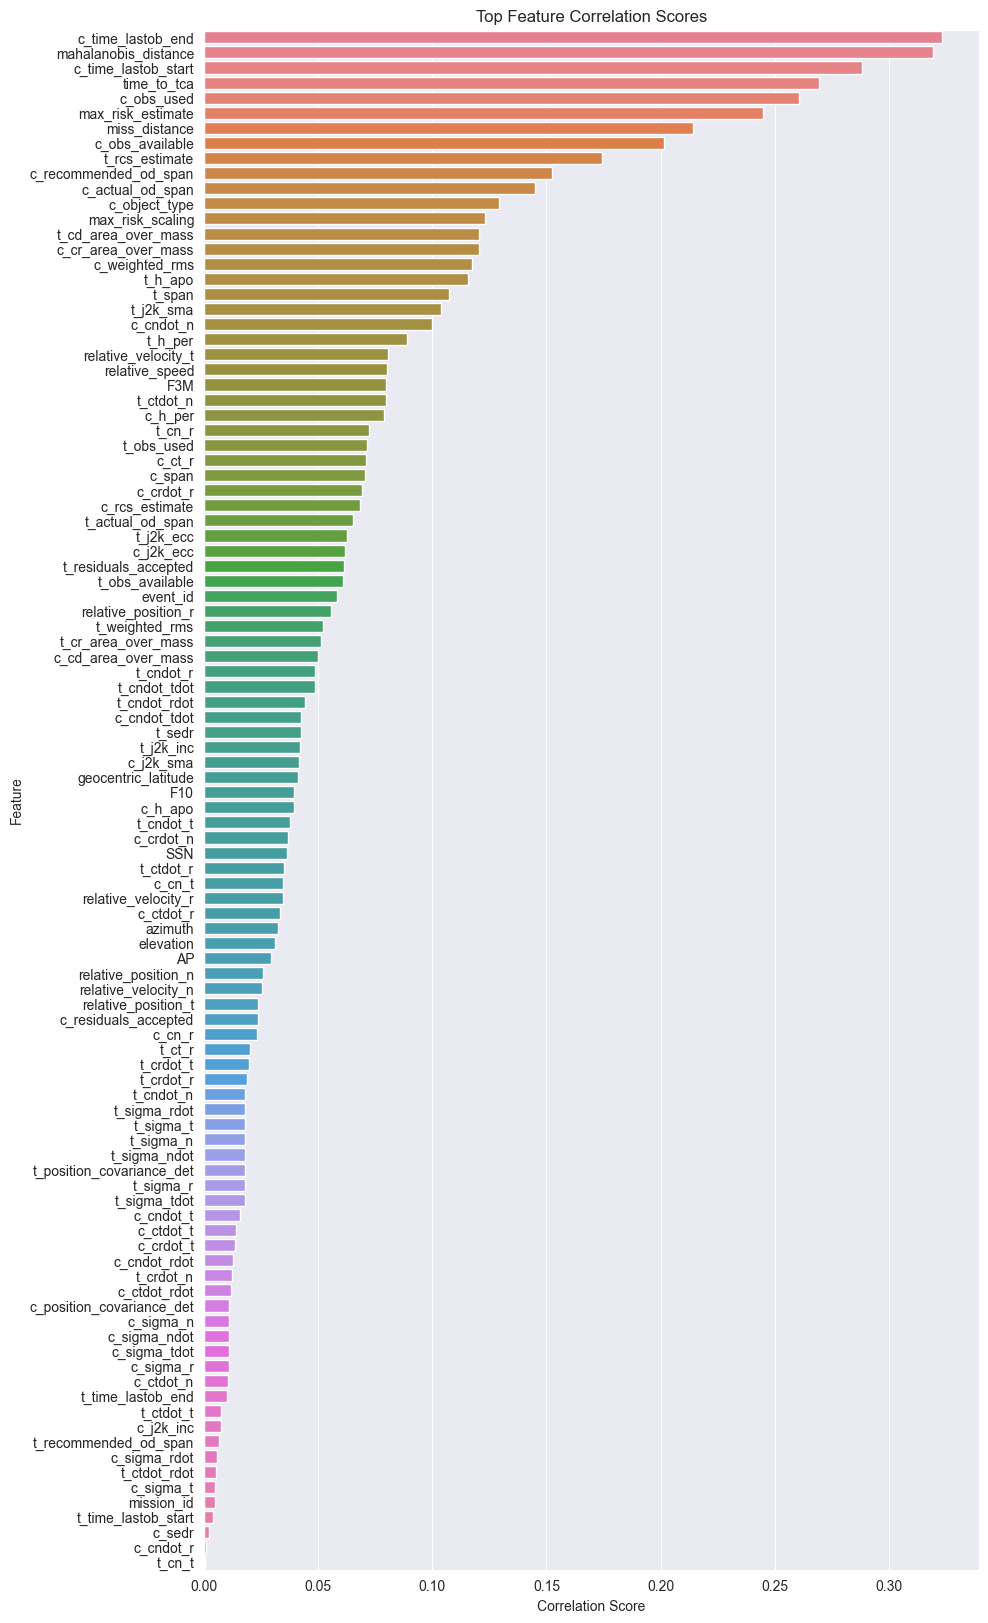

In [38]:
# Label encode categorical columns (e.g., "c_object_type")
label_encode_column(df_filtered, "c_object_type")

# Calculate correlation matrix
correlation_matrix = df_filtered.corr()

# Identify features with high correlation with the target variable ("risk")
target_correlation = correlation_matrix["risk"].abs().sort_values(ascending=False)
best_features = target_correlation[1:]  # Exclude the target variable
print("Top Features:")
print(best_features.head(10))

# Plot the correlation scores of the top features
plt.figure(figsize=(10, 20))
sns.barplot(x=best_features.values, y=best_features.index, hue=best_features.index)
plt.title("Top Feature Correlation Scores")
plt.xlabel("Correlation Score")
plt.ylabel("Feature")
plt.show()

selected_features_corr = best_features[:6].index.tolist()

## Univariate Selection

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


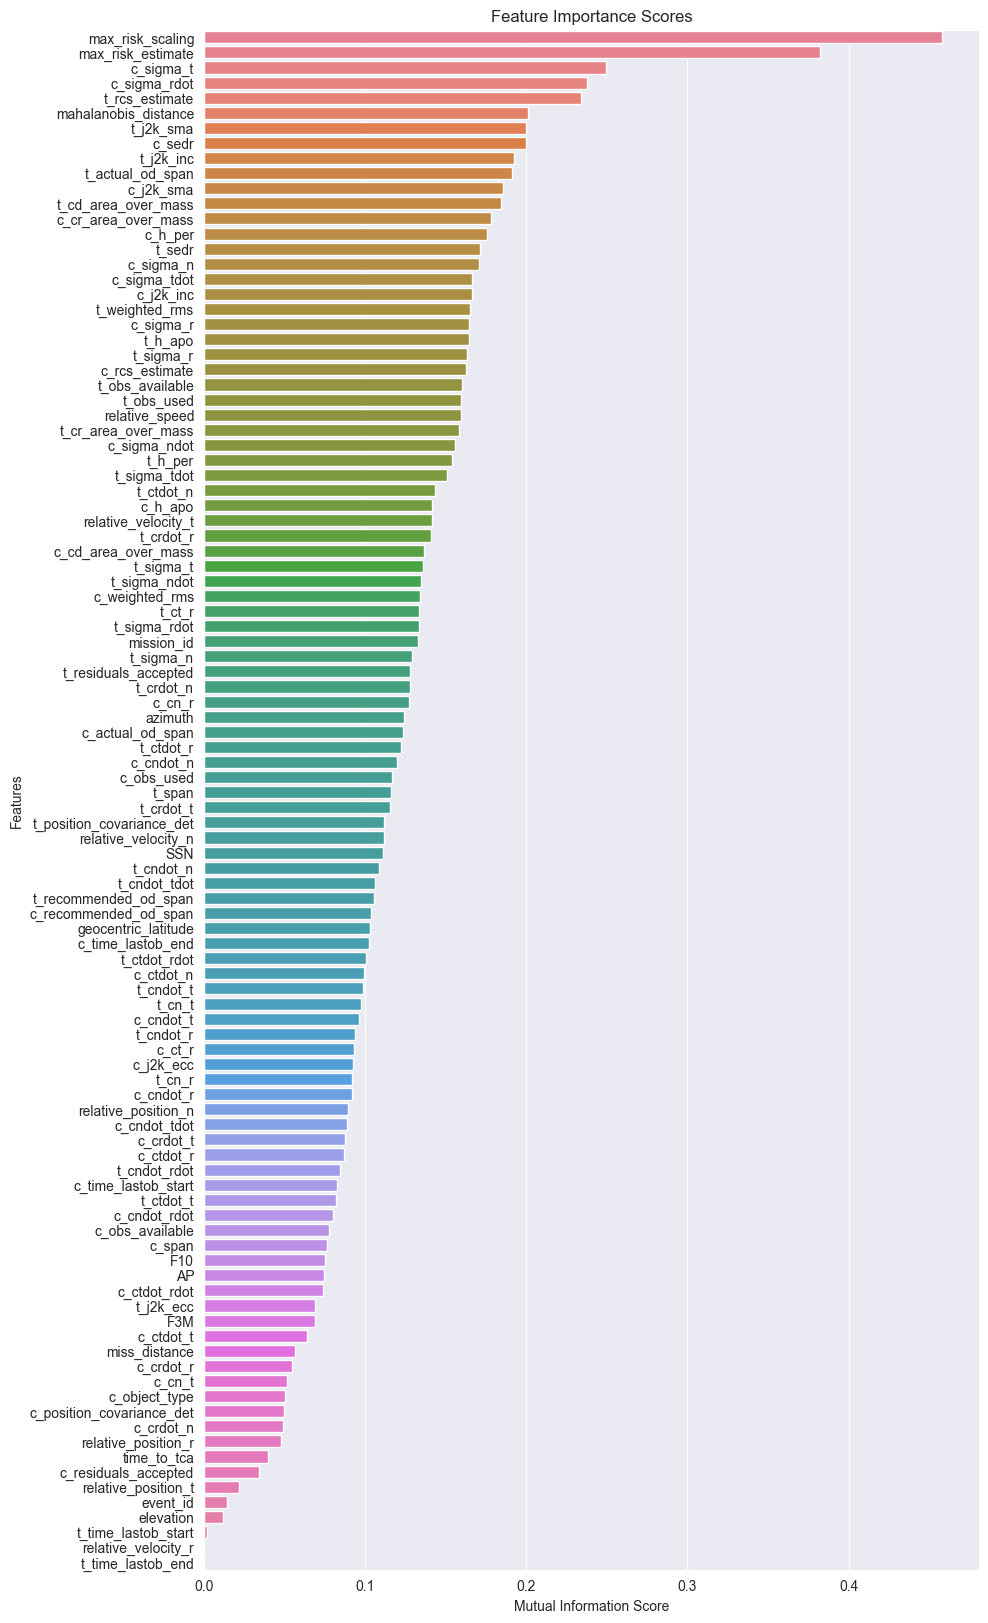

In [39]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Assuming you have the necessary functions like load_data, filter_data, and label_encode_column

# Load data
df = load_data()
df_filtered = filter_data(df)

df_filtered.dropna(axis=0, how='any', inplace=True)

label_encode_column(df_filtered, "c_object_type")

features = df_filtered.drop(["risk"], axis=1)
target = df_filtered["risk"]

# Feature selection using SelectKBest with mutual_info_regression
selector = SelectKBest(score_func=mutual_info_regression, k='all') 
X_selected = selector.fit_transform(features, target)

# Get the selected feature names
selected_feature_names = features.columns[selector.get_support()]

# Get the feature scores
feature_scores = selector.scores_

# Create a DataFrame with selected features and their scores
selected_features_df = pd.DataFrame({'Feature': selected_feature_names, 'Score': feature_scores[selector.get_support()]})
selected_features_df = selected_features_df.sort_values(by='Score', ascending=False)

# Plot the feature scores using Seaborn
plt.figure(figsize=(10, 20))
sns.barplot(x='Score', y='Feature', data=selected_features_df, hue='Feature')

plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Feature Importance Scores')
plt.show()

selected_features_kbest = selected_features_df[:2]
selected_features_kbest = selected_features_kbest['Feature'].tolist()

## Feature Importance with ExtraTreesRegressor

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


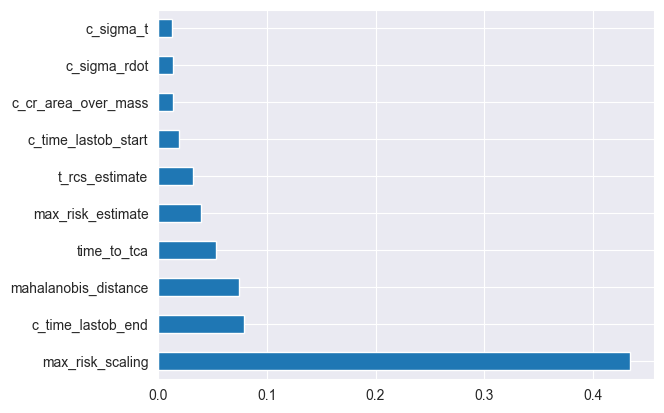

Index(['max_risk_scaling', 'c_time_lastob_end', 'mahalanobis_distance',
       'time_to_tca', 'max_risk_estimate'],
      dtype='object')


In [40]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler

# Load data
df = load_data()
df_filtered = filter_data(df)

# Drop NaN values
df_filtered.dropna(axis=0, how='any', inplace=True)

# Encode categorical column
label_encode_column(df_filtered, "c_object_type")

# Separate features and target
features = df_filtered.drop(["risk"], axis=1)
target = df_filtered["risk"]

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train the model
model = ExtraTreesRegressor()
model.fit(features_scaled, target)


# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
selected_features_regressor = feat_importances.nlargest(5).index.tolist()

## D-Wave scikit-learn Plugin using a quantum-classical hybrid solver.

In [41]:
from dwave.plugins.sklearn import SelectFromQuadraticModel

from dwave.cloud import Client
with Client.from_config() as client:
    solver = client.get_solver()
    solver.id       
    
# Assuming you have already loaded and processed your data
df = load_data()
df_filtered = filter_data(df)

# Drop NaN values
df_filtered.dropna(axis=0, how='any', inplace=True)

# Encode categorical column
label_encode_column(df_filtered, "c_object_type")

# Separate features and target
features = df_filtered.drop(["risk"], axis=1)
target = df_filtered["risk"]

# Apply SelectFromQuadraticModel
selector = SelectFromQuadraticModel(num_features=10)
X_new = selector.fit_transform(features.values, target.values)

# Get the selected features
selected_features_indices = selector.get_support(indices=True)

# Print the selected features
selected_features = features.columns[selected_features_indices]
print("Selected Features:")
print(selected_features)

selected_features_dwave = selected_features.tolist()

# Index(['event_id', 'time_to_tca', 'max_risk_estimate', 'miss_distance',
#        'c_time_lastob_end', 'c_obs_used', 'c_cr_area_over_mass', 'c_cndot_n',
#        'geocentric_latitude', 'mahalanobis_distance'],
#       dtype='object')

# Index(['event_id', 'time_to_tca', 'max_risk_estimate', 'max_risk_scaling',
#        'miss_distance', 'relative_speed', 'relative_position_t',
#        'relative_velocity_r', 't_residuals_accepted', 't_rcs_estimate',
#        't_cd_area_over_mass', 't_cndot_r', 'c_time_lastob_start',
#        'c_time_lastob_end', 'c_obs_available', 'c_obs_used', 'c_weighted_rms',
#        'c_cr_area_over_mass', 'c_j2k_ecc', 'c_cndot_n', 'geocentric_latitude',
#        'azimuth', 'mahalanobis_distance', 'F3M'],
#       dtype='object')

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB
Selected Features:
Index(['event_id', 'time_to_tca', 'max_risk_estimate', 'miss_distance',
       'c_time_lastob_end', 'c_obs_used', 'c_cr_area_over_mass', 'c_cndot_n',
       'geocentric_latitude', 'mahalanobis_distance'],
      dtype='object')


In [46]:
# Combine all selected features into a single list without duplicates
selected_features_final = list(set(selected_features_corr + selected_features_kbest + selected_features_regressor + selected_features_dwave))

# Print or use the new list
print("All Selected Features:")
print(selected_features_final)


All Selected Features:
['max_risk_estimate', 'c_cndot_n', 'c_time_lastob_end', 'max_risk_scaling', 'geocentric_latitude', 'time_to_tca', 'miss_distance', 'event_id', 'c_obs_used', 'c_time_lastob_start', 'c_cr_area_over_mass', 'mahalanobis_distance']
